## 第二十九讲：基于密度的聚类（density-based clustering）
___

基于密度的聚类方法的指导思想是：只要样本点的密度大于设定的阈值，则将该样本添加到最近的簇中。

这类算法能克服基于距离的算法只能发现“凸”聚类的缺点，可发现“非凸”的聚类，且对噪声数据不敏感。但计算密度单元的计算复杂度，需要建立空间索引来降低计算量。

常见的基于密度的聚类方法有：DBSCAN、密度最大值算法等。

In [6]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import cluster
from sklearn import datasets
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

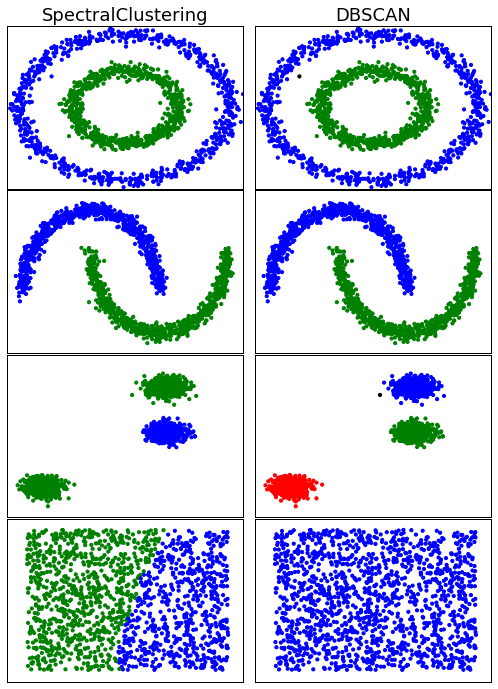

In [7]:
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

colors = np.array([x for x in 'bgrcmykbgrcmykbgrcmykbgrcmyk'])
colors = np.hstack([colors] * 20)

clustering_names = ['SpectralClustering', 'DBSCAN']

plt.figure(figsize=(2*2 + 3, 9.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)
plot_num = 1

datasets = [noisy_circles, noisy_moons, blobs, no_structure]
for i_dataset, dataset in enumerate(datasets):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=0.3)

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors=10, include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # create clustering estimators
    spectral = cluster.SpectralClustering(n_clusters=2,
                                          eigen_solver='arpack',
                                          affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=.2)

    clustering_algorithms = [spectral, dbscan]

    for name, algorithm in zip(clustering_names, clustering_algorithms):
        # predict cluster memberships
        algorithm.fit(X)
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        # plot
        plt.subplot(4, len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)
        plt.scatter(X[:, 0], X[:, 1], color=colors[y_pred].tolist(), s=10)

        if hasattr(algorithm, 'cluster_centers_'):
            centers = algorithm.cluster_centers_
            center_colors = colors[:len(centers)]
            plt.scatter(centers[:, 0], centers[:, 1], s=100, c=center_colors)
        plt.xlim(-2, 2)
        plt.ylim(-2, 2)
        plt.xticks(())
        plt.yticks(())
        plot_num += 1

## 1. DBSCAN算法

DBSCAN（Density-Based Spatial Clustering of Applications with Noise）是一种比较有代表性的基于密度的聚类算法。

与划分和层次聚类方法不同，它将簇定义为密度相连的点的最大集合,能够把具有足够高密度的区域划分为簇，并可在有“噪声”的数据中发现任意形状的聚类。

### 1.1 重要概念

- __样本$i$的$\epsilon$邻域__：$N(x_i, \epsilon) = \{x_j \lvert \lVert x_j - x_i \rVert \le \epsilon \}$

- __核心样本__：如果样本$i$的$\epsilon$邻域中至少包含$m$个样本（不包含自身），则称样本$i$为核心样本。

- __直接密度可达__：如果样本$p$在核心样本$q$的$\epsilon$邻域内，则称$p$是$q$直接密度可达的。注意，直接密度可达不是对称的。

- __密度可达__：如果存在一个样本链$p_1, \ldots, p_n$，且$p_{i+1}$是$p_i$关于$\epsilon$和$m$直接密度可达的，则样本$p_n$是$p_1$关于$\epsilon$和$m$密度可达的。直接密度可达是密度可达的一种特例，right？

- __密度相连__：如果存在样本$o$，使得样本$p$和$q$是从$o$关于$\epsilon$和$m$密度可达的，则我们称$p$和$q$是关于$\epsilon$和$m$密度相连的。

- __基于密度的簇__：最大的密度相连的样本的集合。

- __噪声__：不被包含在任何簇中的样本称为噪声。

### 1.2 DBSCAN算法流程

(1) 如果样本$p$的$\epsilon$-邻域中包含多于$m$个样本，则创建一个$p$作为核心样本的新簇；

(2) 寻找并合并核心样本直接密度可达的样本；

(3) 没有新样本可以更新簇时，算法结束。

由此可知：

(1) 每个簇至少包含一个核心样本；

(2) 非核心样本也可以是簇的一部分，构成簇的边缘（edge）；

(3) 我们可将样本过少的簇当作噪声。

## 2. 密度最大值聚类

密度最大值聚类是一种简洁、优美的聚类算法，可以识别各种形状的类簇, 并且其参数相比其他聚类算法，很容易确定。

### 2.1 重要概念

- __局部密度__：
$$
\rho_i = \sum_j \chi(d_{ij} - d_c), \chi(x) = \left\{
\begin{array}{ll}
1, & x < 0\\
0, & \mbox{otherwise}
\end{array}
\right.
$$
计算的是到样本$i$的距离小于$d_c$的样本的数量，其中$d_c$是一个截断距离（thresholding）。由于密度最大值聚类算法只对$\rho_i$的相对值敏感，因此对$d_c$的选择是鲁棒的。一个常规的选择$d_c$的做法是使得平均每个样本的邻居书目为总样本数量的1-2%。

- __高局部密度点距离__：
$$
\delta_i = \min_{j: \rho_j > \rho_i} d_{ij}
$$
也就是计算到局部密度值大于$\rho_i$的样本点到$i$的最小距离。

对于密度最大的样本，将其$\delta_i$设为无穷大。

我们将这戏称为<font color="red">“找土豪的算法”</font>，如果比某人有钱的人离这人的最近距离非常大，但从全局来说，比他有钱的人海了去了，则此人一定是土豪，对不？而对于马云来说，比他有钱的人不多，所以不算是“土豪”。

- 只有那些密度是局部或全局最大的样本才会有原高出正常值的$\delta_i$值。

### 2.2 如何找到聚类簇中心

- 那些同时具有高$\rho_i$和$\delta_i$的样本可作为潜在的聚类簇中心；

- 确定簇中心之后，其他点按照距离已知聚类簇的中心最近进行聚类，也可按照密度可达的方法进行聚类。

- 高密距离$\delta_i$较大但局部密度$\rho_i$较小的点是异常点。

### 2.3 边界和噪声

在聚类分析中，常常需要确定每个样本点划分给某个聚类簇的可靠性:

- 我们可以为每个簇定义一个边界区域（border region），也就是划分给该簇但是距离其他簇的样本点的距离小于$d_c$的样本点的集合。

- 然后为每个簇找到其边界区域的局部密度最大的点，假定其局部密度为$\rho_h$。

- 该簇中所有局部密度大于$\rho_h$的样本被认为是簇核心的一部分(亦即将该点划分给该类簇的可靠性很大)；而其余的样本点被认为是该类簇的光晕(halo)，换言之，很可能是噪声。